# Quetion 01
#### In this question, using the knowledge on blob detection, i.e., using Laplacian of Gaussians and scale-space extrema detection, we will detect and draw circles in the sunflower field image. Use the sunflower field image provided

In [31]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from scipy import linalg
from scipy.optimize import minimize

In [ ]:
def create_laplacian_of_gaussian_kernel(sigma):
    """
    Create the Laplacian of Gaussian kernel with normalization
    """
    # Set the kernel size 
    half_width = int(3 * sigma)  # Half width of kernal
    size = 2 * half_width + 1    # Make it odd size
    
    # Create coordinate grid for the kernal
    x = np.arange(-half_width, half_width + 1)
    y = np.arange(-half_width, half_width + 1)
    X, Y = np.meshgrid(x, y)
    
    # Calculate Laplacian of Gaussian formula
    r_squared = X**2 + Y**2
    log_kernel = ((r_squared) / (2 * sigma**2) - 1) * np.exp(-r_squared / (2 * sigma**2)) / (np.pi * sigma**4)
    
    # Multiply by sigma^2 for scale invariance
    scaled_log_kernel = (sigma ** 2) * log_kernel
    
    #scaled_log_kernel = np.exp(-r_squared / (2 * sigma**2)) * (r_squared-2*sigma**2)
    
    return scaled_log_kernel


Image size: (360, 360)
Radii: [ 2  3  4  5  6  7  8  9 10 11 12 13]
Sigma values: [1.41421356 2.12132034 2.82842712 3.53553391 4.24264069 4.94974747
 5.65685425 6.36396103 7.07106781 7.77817459 8.48528137 9.19238816]
Processing sigma = 1.41 (radius = 2)
Processing sigma = 2.12 (radius = 3)
Processing sigma = 2.83 (radius = 4)
Processing sigma = 3.54 (radius = 5)
Processing sigma = 4.24 (radius = 6)
Processing sigma = 4.95 (radius = 7)
Processing sigma = 5.66 (radius = 8)
Processing sigma = 6.36 (radius = 9)
Processing sigma = 7.07 (radius = 10)
Processing sigma = 7.78 (radius = 11)
Processing sigma = 8.49 (radius = 12)
Processing sigma = 9.19 (radius = 13)
Finding maxima for radius=2, sigma=1.41
Finding maxima for radius=3, sigma=2.12
Finding maxima for radius=4, sigma=2.83
Finding maxima for radius=5, sigma=3.54
Finding maxima for radius=6, sigma=4.24
Finding maxima for radius=7, sigma=4.95
Finding maxima for radius=8, sigma=5.66
Finding maxima for radius=9, sigma=6.36
Finding maxima 

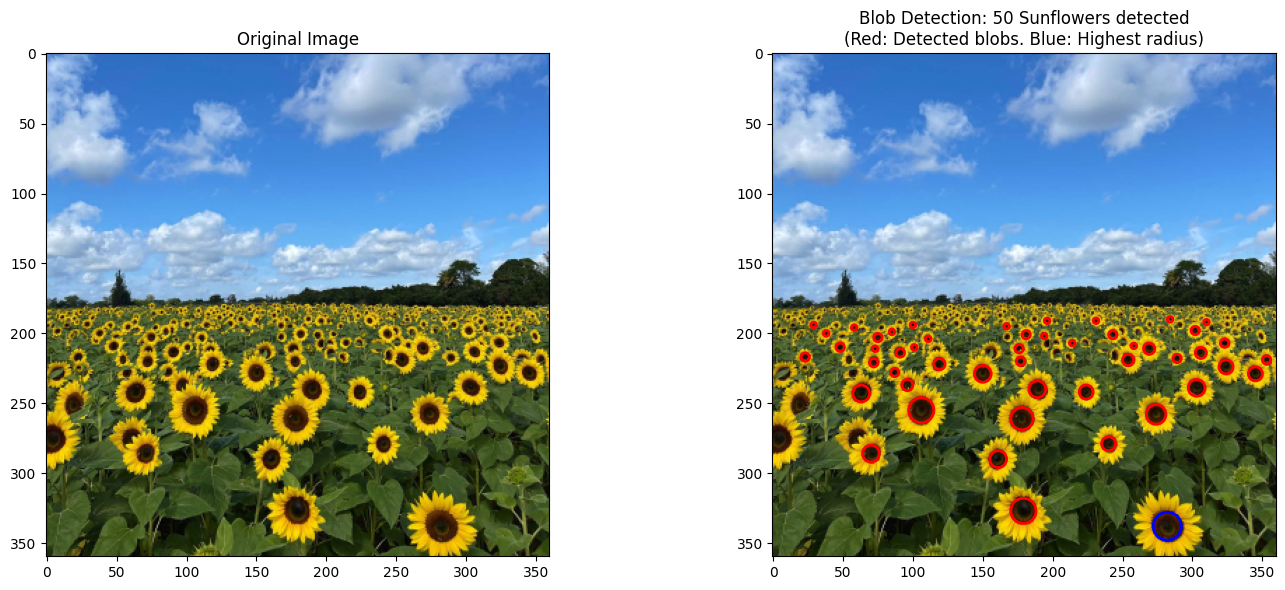


Top 5 largest blobs:
Rank | Center (x,y) | Radius | Sigma | Response
-------------------------------------------------------
   1 | (282.0, 338.0) |   10.0 |  7.07 | 0.3304
   2 | (106.0, 255.0) |    9.0 |  6.36 | 0.3426
   3 | (179.0, 327.0) |    9.0 |  6.36 | 0.3274
   4 | (178.0, 261.0) |    8.0 |  5.66 | 0.3299
   5 | (274.0, 258.0) |    7.0 |  4.95 | 0.3206


In [61]:
# Load the image at 1/4 resolution
im = cv.imread('the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
gray = gray.astype(np.float32) / 255.0

print(f"Image size: {gray.shape}")

# By looking at the image, selecta rough range for the blob radius sizes
radius_start = 2
radius_end = 13  
num_scales = radius_end-radius_start+1  
radii = np.arange(radius_start, radius_end + 1)
sigma_values = radii / np.sqrt(2)  # Convert radius to sigma: sigma = r/√2

print(f"Radii: {radii}")
print(f"Sigma values: {sigma_values}")


h, w = gray.shape
scale_space = np.zeros((h, w, num_scales), dtype=np.float32) # To hold the convolution outputs for each sigma

for i, sigma in enumerate(sigma_values):
    print(f"Processing sigma = {sigma:.2f} (radius = {radii[i]})")
    
    # Create the Laplacian of Gaussian kernel
    log_kernel = create_laplacian_of_gaussian_kernel(sigma)
    
    # Convolve with image
    response = cv.filter2D(gray, cv.CV_32F, log_kernel)
    #squared_response = np.square(response)  # Make all responses positive
    
    # Store in scale space
    scale_space[:, :, i] = response

blobs = []

# Search for local maxima in 3D scale space
for scale_idx in range(num_scales):
    sigma = sigma_values[scale_idx]
    radius = radii[scale_idx]  # Direct radius value
    current_response = scale_space[:, :, scale_idx]
    
    print(f"Finding maxima for radius={radius}, sigma={sigma:.2f}")
    
    # Perform a neighborhood search (3x3). So select k = 1
    k = 1 
    
    # Use percentile to automatically set threshold. This is used to only get the strongest responses
    scale_threshold = np.percentile(current_response, 99.97)
    
    for y in range(k, h - k):
        for x in range(k, w - k):
            current_val = current_response[y, x]
            
            # Skip if below threshold 
            if current_val < scale_threshold:
                continue
            
            # Check if this is a local maximum in 3x3 neighborhood
            is_maximum = True
            for dy in range(-k, k + 1):
                for dx in range(-k, k + 1):
                    if dy == 0 and dx == 0:
                        continue
                    if current_response[y + dy, x + dx] > current_val:
                        is_maximum = False
                        break
                if not is_maximum:
                    break
            
            # Compare with adjacent scales
            if is_maximum and scale_idx > 0:
                if current_val < scale_space[y, x, scale_idx - 1]:
                    is_maximum = False
            
            if is_maximum and scale_idx < num_scales - 1:
                if current_val < scale_space[y, x, scale_idx + 1]:
                    is_maximum = False
            
            # If it's a true maximum, store it
            if is_maximum:
                blobs.append((x, y, radius, sigma, current_val))

print(f"Total number of blobs detected = {len(blobs)}")

# Remove duplicates
final_blobs = []

# Sort blobs by response strength
blobs.sort(key=lambda x: x[4], reverse=True)

for blob in blobs:
    x, y, radius, sigma, response = blob
    
    # Check if this location is already used or overlaps with another
    location_used = False
    for existing_x, existing_y, existing_radius, existing_sigma, existing_response in final_blobs:
        distance = np.sqrt((x - existing_x)**2 + (y - existing_y)**2)

        # If centers are closer than the smaller radius then ignore that location to avoid clustering
        if distance < min(radius, existing_radius):
            location_used = True
            break
    
    if not location_used:
        final_blobs.append(blob)

print(f"Total number of blobs after duplicate removal =  {len(final_blobs)}")

# Sort the original list by radius
final_blobs.sort(key=lambda x: x[2], reverse=True)  # Sort by radius (index 2)

# Draw circles on output image using matplotlib
plt.figure(figsize=(15, 6))

# Create subplot for original image
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
plt.title("Original Image")
#plt.axis('off')

# Create subplot for detected blobs
plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
ax = plt.gca()

# Draw all detected blobs
for i, (x, y, radius, sigma, response) in enumerate(final_blobs):
    # Draw circle
    circle = plt.Circle((x, y), radius, color= 'blue' if i == 0 else 'red', linewidth=2, fill=False)
    ax.add_patch(circle)
    
    # Draw center
    #plt.plot(x, y, 'b+', markersize=8, markeredgewidth=2)

plt.title(f"Blob Detection: {len(final_blobs)} Sunflowers detected\n(Red: Detected blobs. Blue: Highest radius)")
#plt.axis('off')

plt.tight_layout()
plt.show()

# Results
if final_blobs:
    
    print(f"\nTop 5 largest blobs:")
    print("Rank | Center (x,y) | Radius | Sigma | Response")
    print("-" * 55)
    for i, (x, y, radius, sigma, response) in enumerate(final_blobs[:5]):
        print(f"{i+1:4d} | ({x:5.1f}, {y:5.1f}) | {radius:6.1f} | {sigma:5.2f} | {response:.4f}")


Visualizing LoG kernels...


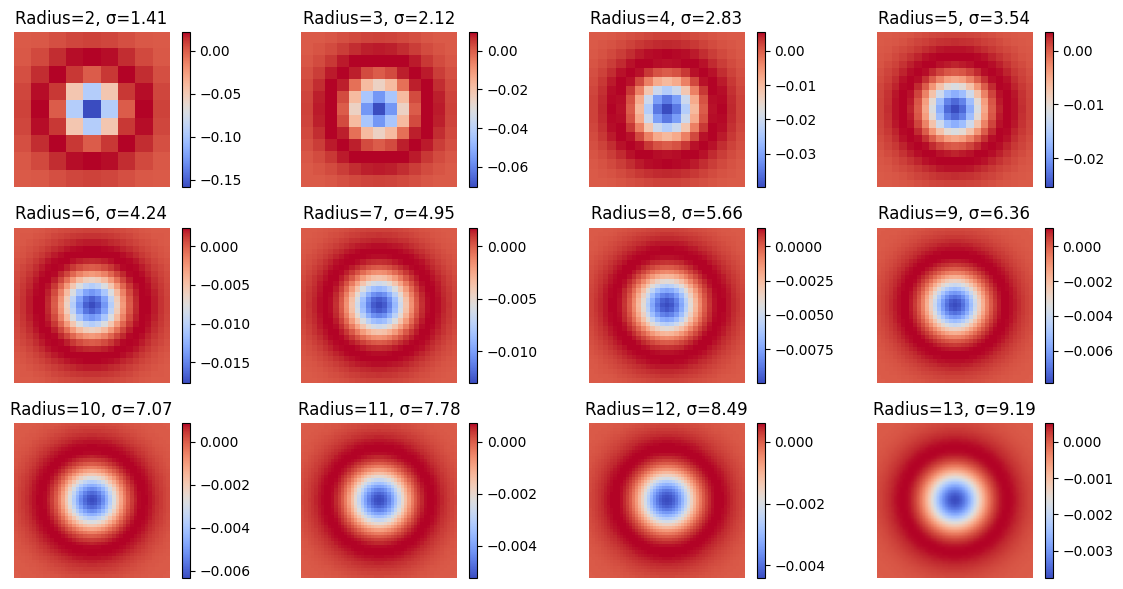

In [ ]:
# Visualize LoG kernels for different scales
print(f"\nVisualizing LoG kernels...")
fig, axes = plt.subplots(3, 4, figsize=(12, 6)) 
sample_radii = radii 
sample_sigmas = sigma_values  

for i, (radius, sigma) in enumerate(zip(sample_radii, sample_sigmas)):
    kernel = create_laplacian_of_gaussian_kernel(sigma)
    ax = axes[i//4, i%4]
    im_plot = ax.imshow(kernel, cmap='coolwarm')
    ax.set_title(f'Radius={radius}, σ={sigma:.2f}')
    ax.axis('off')
    plt.colorbar(im_plot, ax=ax)

for i in range(len(sample_radii)):
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()



Visualizing responses at different scales...


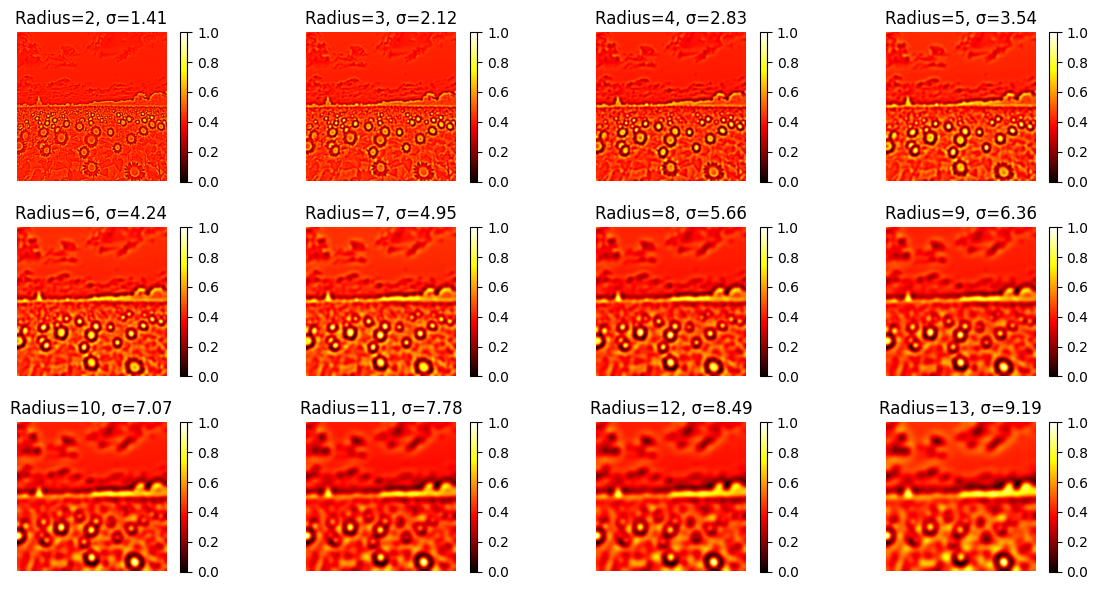

In [ ]:
# Show response images at different scales
print(f"\nVisualizing responses at different scales")
fig, axes = plt.subplots(3, 4, figsize=(12, 6))  
sample_scale_indices = list(range(num_scales))

for i, scale_idx in enumerate(sample_scale_indices):
    ax = axes[i//4, i%4]
    response_img = scale_space[:, :, scale_idx]

    # Normalize for visualization
    response_normalized = (response_img - response_img.min()) / (response_img.max() - response_img.min())
    im_plot = ax.imshow(response_normalized, cmap='hot')
    ax.set_title(f'Radius={radii[scale_idx]}, σ={sigma_values[scale_idx]:.2f}')
    ax.axis('off')
    plt.colorbar(im_plot, ax=ax)

for i in range(len(sample_scale_indices)):
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()


Visualizing LoG kernels...


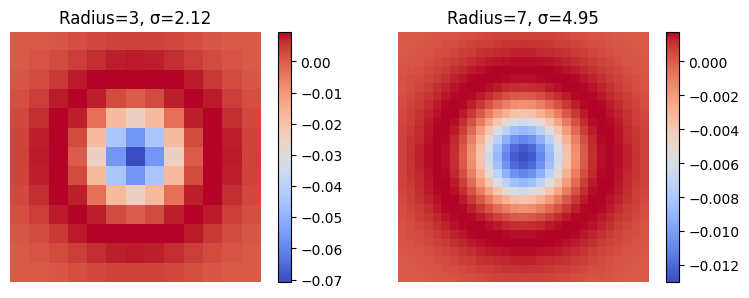

In [379]:
# Visualize LoG kernels for different scales
print(f"\nVisualizing LoG kernels...")
fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Wider for side-by-side
sample_radii = [3, 7]
sample_sigmas = [2.12, 4.95]  

for i, (radius, sigma) in enumerate(zip(sample_radii, sample_sigmas)):
    kernel = create_laplacian_of_gaussian_kernel(sigma)
    ax = axes[i]  # Simple 1D indexing
    im_plot = ax.imshow(kernel, cmap='coolwarm')
    ax.set_title(f'Radius={radius}, σ={sigma:.2f}')
    ax.axis('off')
    plt.colorbar(im_plot, ax=ax)

plt.tight_layout()
plt.show()


# Question 02
#### Fit a line and a circle to a set of noisy points that conform to a line and a circle.

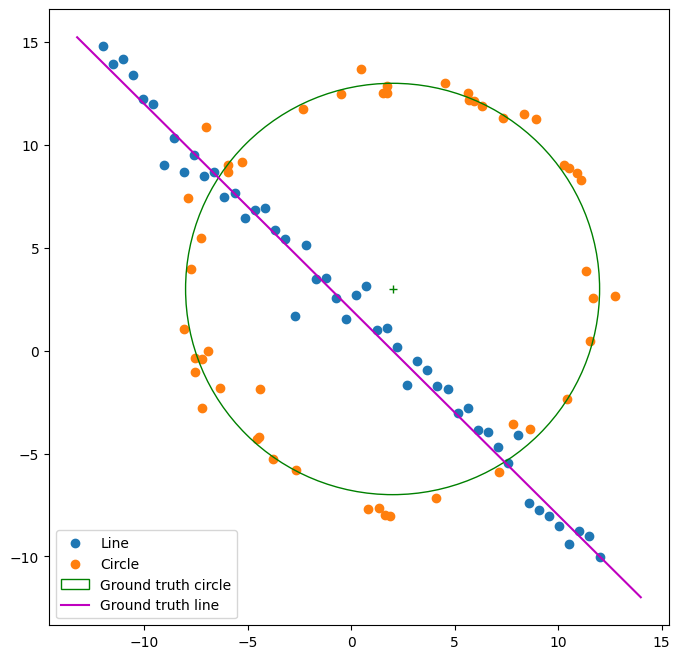

In [380]:
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import numpy as np
# np.random.seed(0)
N = 100
half_n = N//2
r = 10
x0_gt, y0_gt = 2, 3 # Center
s = r / 16
t = np.random.uniform(0, 2*np.pi, half_n)
n = s *np.random.randn(half_n)
x, y = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
s = 1.
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s *np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line)) # All points
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot((x0_gt), (y0_gt), '+', color='g')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m* x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

In [322]:
def fit_line_ransac(data, threshold, n_iterations):
    """
    Fits a line to data using a custom RANSAC algorithm.
    The line model is ax + by - d = 0, where [a, b] is a unit normal vector.
    """
    best_inliers = None
    best_model = None       # Best line parameters (a,b,d)
    best_sample = None      # The 2 points used to generate the best model

    for _ in range(n_iterations):
        # Randomly sample 2 points
        sample_indices = np.random.choice(len(data), 2, replace=False)
        sample = data[sample_indices]

        # Fit a line to the sample
        p1, p2 = sample
        # Line equation ax + by - d = 0
        a = p2[1] - p1[1]
        b = p1[0] - p2[0]
        
        # Ensure it's a unit normal vector
        norm = np.sqrt(a**2 + b**2)
        if norm == 0: continue      #identical points
        a /= norm
        b /= norm
        
        # Calculate d using one of the points
        d = a * p1[0] + b * p1[1]
        model = (a, b, d)

        # Find inliers by calculating the normal distance
        distances = np.abs(a * data[:, 0] + b * data[:, 1] - d)
        inlier_indices = np.where(distances < threshold)[0]     # Returns a tuple. use [0] get the araay which is the only value in the tuple
        inliers = data[inlier_indices]

        # Check if this is the best model so far
        if best_inliers is None or len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = model
            best_sample = sample
    
    # Refit the line using all inliers from the best model (Total Least Squares and SVD)
    if best_inliers is not None and len(best_inliers) > 1:
        centroid = np.mean(best_inliers, axis=0)
        
        centered_data = best_inliers - centroid
        U, S, Vt = np.linalg.svd(centered_data) # U = col vector, S = row vector, Vt = 2x2 matrix
        # The normal to the line is the last right singular vector
        a, b = Vt[-1]
        d = a * centroid[0] + b * centroid[1]
        best_model = (a, b, d)

    return best_model, best_inliers, best_sample

def fit_circle_ransac(data, threshold, n_iterations):
    """
    Fits a circle to data using a custom RANSAC algorithm.
    The circle model is (x - xc)^2 + (y - yc)^2 = r^2.
    """
    best_inliers = None
    best_model = None
    best_sample = None
    
    for _ in range(n_iterations):
        # Randomly sample 3 points
        sample_indices = np.random.choice(len(data), 3, replace=False)
        sample = data[sample_indices]

        # Fit a circle to the sample
        p1, p2, p3 = sample
        A = np.array([
            [2*(p2[0]-p1[0]), 2*(p2[1]-p1[1])],
            [2*(p3[0]-p1[0]), 2*(p3[1]-p1[1])]
        ])
        B = np.array([
            p2[0]**2 + p2[1]**2 - p1[0]**2 - p1[1]**2,
            p3[0]**2 + p3[1]**2 - p1[0]**2 - p1[1]**2
        ])
        try:
            # Solve for the center (xc, yc)
            xc, yc = np.linalg.solve(A, B)
            # Calculate the radius
            r = np.sqrt((p1[0]-xc)**2 + (p1[1]-yc)**2)
            model = (xc, yc, r)
        except np.linalg.LinAlgError:
            # The 3 points are collinear so cannot form a circle
            continue

        # Find inliers by calculating the radial error
        distances = np.abs(np.sqrt((data[:, 0] - xc)**2 + (data[:, 1] - yc)**2) - r)
        inlier_indices = np.where(distances < threshold)[0]
        inliers = data[inlier_indices]

        # Check if this is the best model so far
        if best_inliers is None or len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_model = model
            best_sample = sample

    # Refit the circle using all inliers and scipy.minimize
    def cost_function(params, inliers):
        xc, yc, r = params
        # Sum of squared radial errors
        return np.sum((np.sqrt((inliers[:, 0] - xc)**2 + (inliers[:, 1] - yc)**2) - r)**2)
    
    if best_inliers is not None and len(best_inliers) > 2:
        initial_guess = best_model
        result = minimize(cost_function, initial_guess, args=(best_inliers,), method='L-BFGS-B')
        best_model = result.x

    return best_model, best_inliers, best_sample


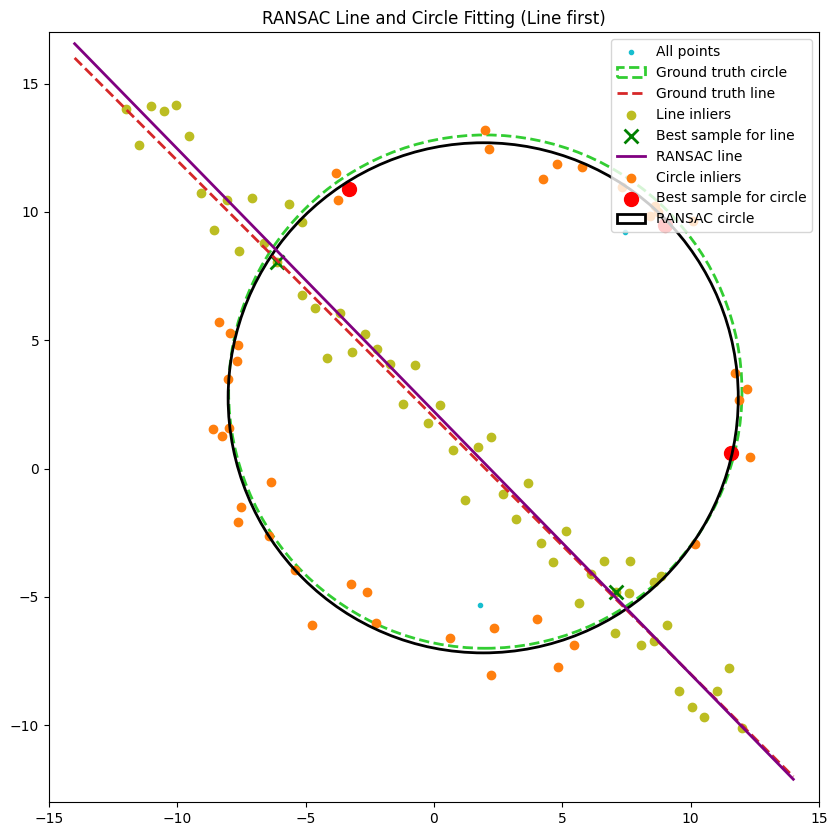

In [365]:
# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x_c, y_c = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x_c.reshape(half_n, 1), y_c.reshape(half_n, 1)))
noise_std_circle = s

s = 1.
m, b = -1, 2 # Ground truth line
x_l = np.linspace(-12, 12, half_n)
y_l = m * x_l + b + s * np.random.randn(half_n)
X_line = np.hstack((x_l.reshape(half_n, 1), y_l.reshape(half_n, 1)))
noise_std_line = s

X = np.vstack((X_circ, X_line))  # All points

# Calculate the no of iterations needed for the line and circle
p = 0.99
e = 0.5
line_iteraions = int(np.ceil(np.log(1-p)/np.log(1 - (1-e)**2)))
circle_iteraions = int(np.ceil(np.log(1-p)/np.log(1 - (1-e)**3)))

# RANSAC Execution for line
line_model, line_inliers, line_sample = fit_line_ransac(X, threshold=1.96*noise_std_line, n_iterations=line_iteraions)

# Subtract line inliers and estimate the circle
if line_inliers is not None:
    # Get indices of all points
    all_indices = np.arange(len(X))
    # Find indices of inliers by comparing array rows
    line_inlier_indices = [i for i, point in enumerate(X) if any(np.array_equal(point, inlier) for inlier in line_inliers)]
    # The remaining points are candidates for the circle
    circle_point_indices = np.delete(all_indices, line_inlier_indices)
    circle_points = X[circle_point_indices]
else:
    print("Line fitting failed")
    circle_points = X 

circle_model, circle_inliers, circle_sample = fit_circle_ransac(circle_points, threshold=1.96*noise_std_circle, n_iterations=circle_iteraions)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect('equal', adjustable='box')
ax.scatter(X[:, 0], X[:, 1], label='All points', c='#17becf', marker='.')

# Plot ground truth for comparison
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='limegreen', fill=False, label='Ground truth circle', lw=2, ls='--')
ax.add_patch(circle_gt)
x_min_gt, x_max_gt = -14, 14
x_gt = np.array([x_min_gt, x_max_gt])
y_gt = m * x_gt + b
ax.plot(x_gt, y_gt, color='#d62728', label='Ground truth line', lw=2, ls='--')

# Plot RANSAC results
if line_inliers is not None:
    ax.scatter(line_inliers[:, 0], line_inliers[:, 1], label='Line inliers', c='#bcbd22')
if line_sample is not None:
    ax.scatter(line_sample[:, 0], line_sample[:, 1], label='Best sample for line', c='green', marker='x', s=100, lw=2)
if line_model is not None:
    a, b_param, d = line_model
    x_min, x_max = -14, 14
    x_vals = np.array([x_min, x_max])
    y_vals = (-a * x_vals + d) / b_param
    ax.plot(x_vals, y_vals, label='RANSAC line', color='purple', lw=2)

if circle_inliers is not None:
    ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], label='Circle inliers', c='#ff7f0e')
if circle_sample is not None:
    ax.scatter(circle_sample[:, 0], circle_sample[:, 1], label='Best sample for circle', c='red', s=100)
if circle_model is not None:
    xc, yc, rc = circle_model
    ransac_circle = plt.Circle((xc, yc), rc, color='black', fill=False, label='RANSAC circle', lw=2)
    ax.add_patch(ransac_circle)

ax.legend(loc='upper right')
ax.set_title('RANSAC Line and Circle Fitting (Line first)')
ax.set_xlim(-15, 15)
ax.set_ylim(-13, 17)
plt.show()

### What if the circle is fitted first?

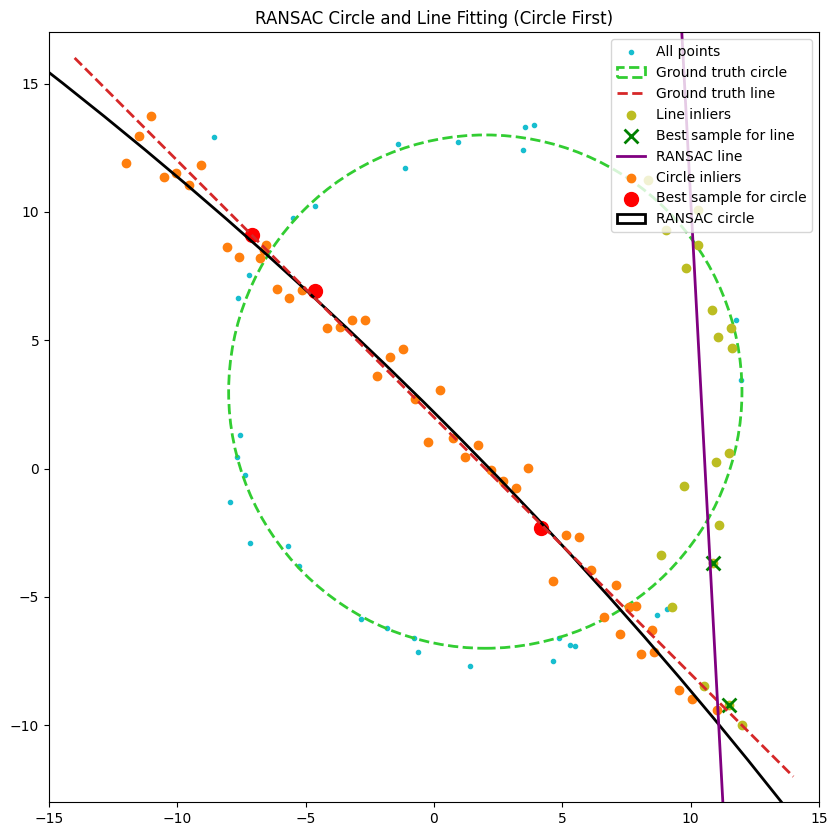

In [361]:
# np.random.seed(0)
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Ground truth center
s = r / 16
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x_c, y_c = x0_gt + (r + n) * np.cos(t), y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x_c.reshape(half_n, 1), y_c.reshape(half_n, 1)))
noise_std_circle = s

s = 1.
m, b = -1, 2 # Ground truth line
x_l = np.linspace(-12, 12, half_n)
y_l = m * x_l + b + s * np.random.randn(half_n)
X_line = np.hstack((x_l.reshape(half_n, 1), y_l.reshape(half_n, 1)))
noise_std_line = s

X = np.vstack((X_circ, X_line))  # All points

# Calculate the no of iterations needed for the line and circle
p = 0.99
e = 0.5
line_iterations = int(np.ceil(np.log(1-p)/np.log(1 - (1-e)**2)))
circle_iterations = int(np.ceil(np.log(1-p)/np.log(1 - (1-e)**3)))

# RANSAC Execution for circle first
circle_model, circle_inliers, circle_sample = fit_circle_ransac(X, threshold=1.96*noise_std_circle, n_iterations=circle_iterations)

# Subtract circle inliers and estimate the line
if circle_inliers is not None:
    # Get indices of all points
    all_indices = np.arange(len(X))
    # Find indices of inliers by comparing array rows
    circle_inlier_indices = [i for i, point in enumerate(X) if any(np.array_equal(point, inlier) for inlier in circle_inliers)]
    # The remaining points are candidates for the line
    line_point_indices = np.delete(all_indices, circle_inlier_indices)
    line_points = X[line_point_indices]
else:
    print("Circle fitting failed")
    line_points = X 

line_model, line_inliers, line_sample = fit_line_ransac(line_points, threshold=1.96*noise_std_line, n_iterations=line_iterations)

# Visualization
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect('equal', adjustable='box')
ax.scatter(X[:, 0], X[:, 1], label='All points', c='#17becf', marker='.')

# Plot ground truth for comparison
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='limegreen', fill=False, label='Ground truth circle', lw=2, ls='--')
ax.add_patch(circle_gt)
x_min_gt, x_max_gt = -14, 14
x_gt = np.array([x_min_gt, x_max_gt])
y_gt = m * x_gt + b
ax.plot(x_gt, y_gt, color='#d62728', label='Ground truth line', lw=2, ls='--')

# Plot RANSAC results
if line_inliers is not None:
    ax.scatter(line_inliers[:, 0], line_inliers[:, 1], label='Line inliers', c='#bcbd22')
if line_sample is not None:
    ax.scatter(line_sample[:, 0], line_sample[:, 1], label='Best sample for line', c='green', marker='x', s=100, lw=2)
if line_model is not None:
    a, b_param, d = line_model
    x_min, x_max = -14, 14
    x_vals = np.array([x_min, x_max])
    y_vals = (-a * x_vals + d) / b_param
    ax.plot(x_vals, y_vals, label='RANSAC line', color='purple', lw=2)

if circle_inliers is not None:
    ax.scatter(circle_inliers[:, 0], circle_inliers[:, 1], label='Circle inliers', c='#ff7f0e')
if circle_sample is not None:
    ax.scatter(circle_sample[:, 0], circle_sample[:, 1], label='Best sample for circle', c='red', s=100)
if circle_model is not None:
    xc, yc, rc = circle_model
    ransac_circle = plt.Circle((xc, yc), rc, color='black', fill=False, label='RANSAC circle', lw=2)
    ax.add_patch(ransac_circle)

ax.legend(loc='upper right')
ax.set_title('RANSAC Circle and Line Fitting (Circle First)')
ax.set_xlim(-15, 15)
ax.set_ylim(-13, 17)
plt.show()

# Question 03

In [369]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [375]:
# image pair 1:
#image_path = "./images_Q3/artwork1.jpg"
#background_path = "./images_Q3/frame1.jpg"

# image pair 2:
image_path = "./images_Q3/poster1.jpg"
background_path = "./images_Q3/billboard1.jpg"

In [394]:
def select_points_on_background(background_img):
    """
    Select 4 points on the background for image placement
    """
    points = []
    temp_img = background_img.copy()
    
    def mouse_callback(event, x, y, flags, param):
        nonlocal temp_img
        if event == cv2.EVENT_LBUTTONDOWN and len(points) < 4:
            points.append([x, y])
            
            # Draw circle for the selected points
            cv2.circle(temp_img, (x, y), 8, (0, 255, 0), -1)
            cv2.putText(temp_img, str(len(points)), (x+15, y-15), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
            
            # Draw connecting lines
            if len(points) > 1:
                cv2.line(temp_img, tuple(points[-2]), tuple(points[-1]), (255, 255, 0), 3)
            if len(points) == 4:
                cv2.line(temp_img, tuple(points[3]), tuple(points[0]), (255, 255, 0), 3)
                cv2.putText(temp_img, "Press 'ENTER' to confirm", (50, 50), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            
            cv2.imshow("Select image Position", temp_img)
            print(f"Point {len(points)} selected at ({x}, {y})")
    
    cv2.imshow("Select image Position", background_img)
    cv2.setMouseCallback("Select image Position", mouse_callback)
    
    
    # Clicking order for 4 points to define the position
    # Order:
    #       1)top-left
    #       2)top-right
    #       3)bottom-right
    #       4)bottom-left 
    
    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == 13 and len(points) == 4:  # ENTER to confirm
            break
        elif key == ord('r'):  # press r to Reset
            points = []
            temp_img = background_img.copy()
            cv2.imshow("Select image Position", temp_img)
            print("Points reset")
        elif key == 27:  # press ESC to cancel
            cv2.destroyAllWindows()
            return None
    
    cv2.destroyAllWindows()
    return np.array(points, dtype=np.float32)

def warp_and_blend_image(image, background_img, destination_points):
    """
    Warp the image to fit the selected background area and blend it
    """
    # Get image dimensions
    h_image, w_image = image.shape[:2]
    
    # Source points which are the corners of image
    source_points = np.array([
        [0, 0],              # Top-left
        [w_image-1, 0],        # Top-right
        [w_image-1, h_image-1],  # Bottom-right
        [0, h_image-1]         # Bottom-left
    ], dtype=np.float32)
    
    # Calculate homography matrix
    H, status = cv2.findHomography(source_points, destination_points)
    print(H)
    
    # Warp the image
    h_background, w_background = background_img.shape[:2]
    warped_image = cv2.warpPerspective(image, H, (w_background, h_background))
    
   # Create mask for blending
    mask = np.ones((h_image, w_image), dtype=np.uint8) * 255
    warped_mask = cv2.warpPerspective(mask, H, (w_background, h_background))

    # Blend the image into the background
    result = background_img.copy()
    result[warped_mask > 0] = warped_image[warped_mask > 0]  

    return result

def display_final_result(original_background, original_image, final_result, destination_points):
    """
    Display the results
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original background
    axes[0].imshow(cv2.cvtColor(original_background, cv2.COLOR_BGR2RGB))
    axes[0].set_title('Original background', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    
    # Original image
    axes[1].imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
    axes[1].set_title('Image to Display', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    
    # Final result
    axes[2].imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
    axes[2].set_title('Final Result', fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # show with OpenCV
    cv2.imshow("Final Result", final_result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Point 1 selected at (723, 337)
Point 2 selected at (1055, 314)
Point 3 selected at (1088, 467)
Point 4 selected at (683, 482)
[[ 5.62561605e-01 -6.14850029e-01  7.23000000e+02]
 [-9.73760598e-02  2.34929660e-01  3.37000000e+02]
 [-1.50879171e-04 -6.74099377e-04  1.00000000e+00]]


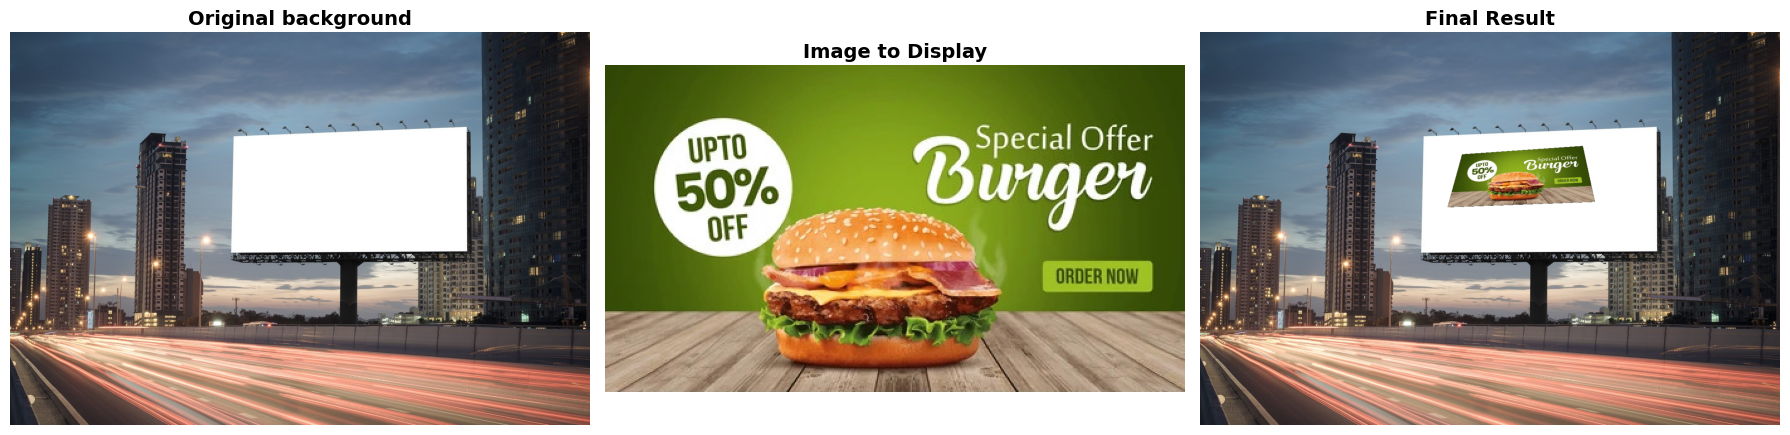

warping successfull!


In [395]:
def transform_image():
    """
    warp and blend the image to a given background
    """
    background_img = cv2.imread(background_path) 
    image = cv2.imread(image_path)  
    
    if background_img is None or image is None:
        print("Error: Could not load images. Please check file paths.")
        return
    
    h_background, w_background = background_img.shape[:2]
    h_image, w_image = image.shape[:2]
    
    # Select points on background
    background_points = select_points_on_background(background_img)
    if background_points is None:
        return
    
    # Warp the image directly to fit the selected area
    final_result = warp_and_blend_image(image, background_img, background_points)
    
    # Display the final result
    display_final_result(background_img, image, final_result, background_points)
    
    return final_result

# Execute
if __name__ == "__main__":
    result = transform_image()
    
    if result is not None:
        print("warping successfull!")
    else:
        print("warping failed.")

# Question 04

Found 87 good matches.


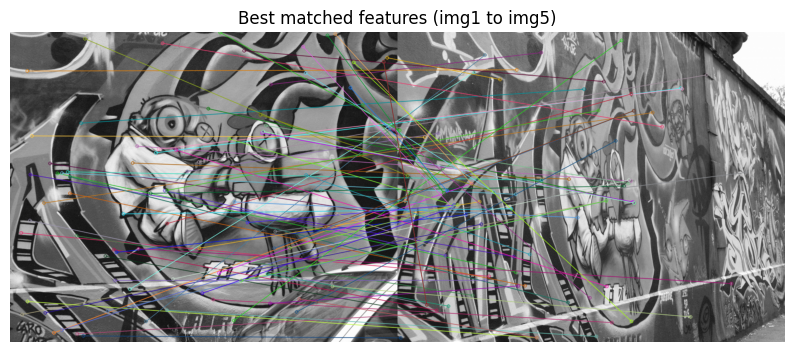

Using ground truth homography from graf/graf/H1to5p:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]


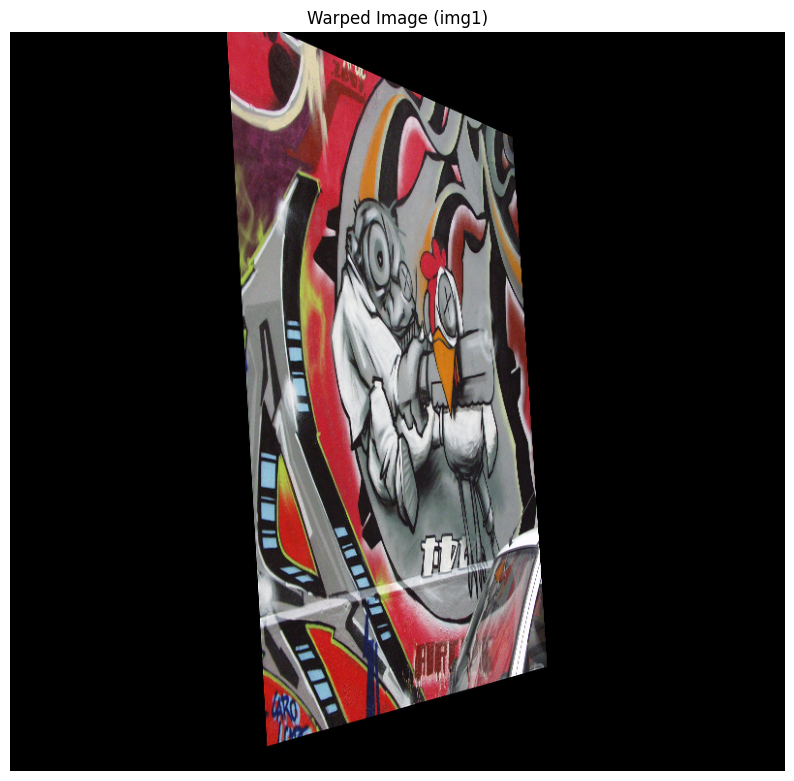

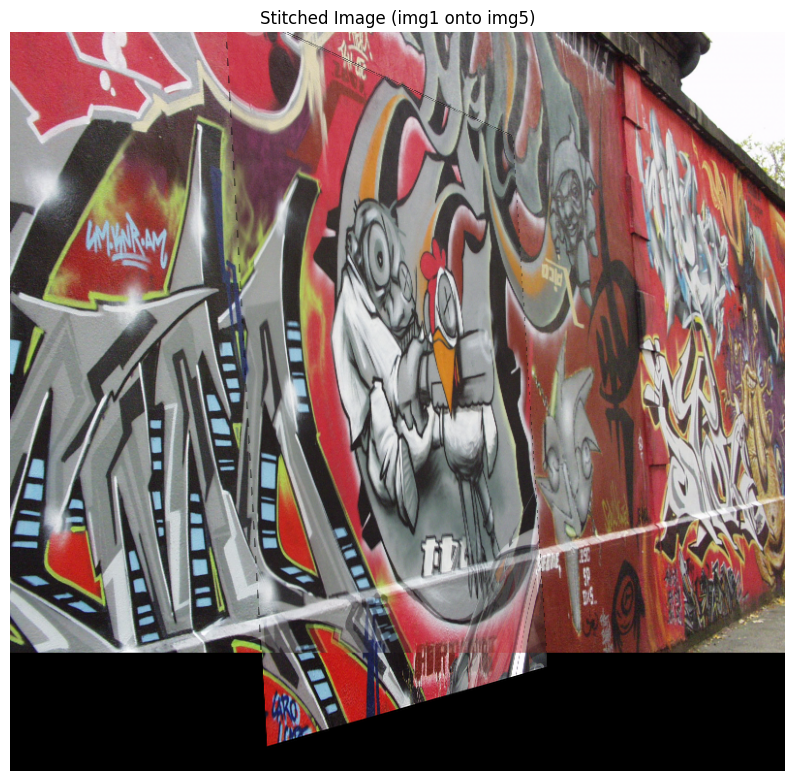

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform

# Set to True to stitch img3 onto img5, False for img1
USE_IMG3 = False  # Default to img3 since you have H3to5p

# Load images
img_ref = 'graf/graf/img3.ppm' if USE_IMG3 else 'graf/graf/img1.ppm'
img1 = cv2.imread(img_ref)
img5 = cv2.imread('graf/graf/img5.ppm')

# Check if images loaded
assert img1 is not None, f"Failed to load {img_ref}"
assert img5 is not None, "Failed to load img5.ppm"

# Convert to RGB for consistency
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)

def get_sift_features(img1, img2):
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    sift = cv2.SIFT_create(nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)
    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)
    if descriptors1 is None or descriptors2 is None:
        raise ValueError("No descriptors found in one or both images.")
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    best_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]
    return best_matches, keypoints1, keypoints2

def get_inliers(src_full, dst_full, tform, thres):
    dst_check = tform(src_full)
    errors = np.sqrt(np.sum((dst_check - dst_full) ** 2, axis=1))
    return np.where(errors < thres)[0]

def find_best_homography(good_matches, keypoints1, keypoints2):
    src_full = np.array([keypoints1[m.queryIdx].pt for m in good_matches], dtype=np.float32)
    dst_full = np.array([keypoints2[m.trainIdx].pt for m in good_matches], dtype=np.float32)
    if len(src_full) < 4:
        raise ValueError(f"Not enough matches ({len(src_full)} < 4) to compute homography.")
    num_points = 4
    thres = 1.0  # Reference code's strict threshold
    iters = 200  # Reference code's iteration count
    min_inliers = 4
    best_homography = None
    best_inlier_count = 0
    best_inliers = None
    np.random.seed(62)
    for i in range(iters):
        chosen_matches = np.random.choice(good_matches, num_points, replace=False)
        src_points = np.array([keypoints1[m.queryIdx].pt for m in chosen_matches], dtype=np.float32)
        dst_points = np.array([keypoints2[m.trainIdx].pt for m in chosen_matches], dtype=np.float32)
        try:
            tform = transform.estimate_transform('projective', src_points, dst_points)
            inliers = get_inliers(src_full, dst_full, tform, thres)
            if len(inliers) > best_inlier_count:
                best_inlier_count = len(inliers)
                best_homography = tform
                best_inliers = inliers
        except:
            continue
    if best_inlier_count >= min_inliers:
        src_inliers = src_full[best_inliers]
        dst_inliers = dst_full[best_inliers]
        best_homography = transform.estimate_transform('projective', src_inliers, dst_inliers)
        print(f"Custom RANSAC: Best no. of inliers = {best_inlier_count}")
    else:
        print("Custom RANSAC failed. Trying OpenCV's findHomography...")
        H, mask = cv2.findHomography(src_full, dst_full, cv2.RANSAC, ransacReprojThreshold=5.0)
        best_inlier_count = np.sum(mask) if mask is not None else 0
        if H is None or best_inlier_count < min_inliers:
            raise ValueError(f"RANSAC failed. Only {best_inlier_count} inliers found.")
        best_homography = transform.ProjectiveTransform(matrix=H)
        print(f"OpenCV RANSAC found {best_inlier_count} inliers.")
    return best_homography, best_inliers

# Get SIFT features and matches (for visualization and part (a)/(b))
good_matches, keypoints1, keypoints5 = get_sift_features(img1, img5)
print(f"Found {len(good_matches)} good matches.")

# Visualize matches
matched_img = cv2.drawMatches(cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY), keypoints1,
                              cv2.cvtColor(img5, cv2.COLOR_RGB2GRAY), keypoints5,
                              good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(10, 10))
plt.imshow(matched_img, cmap='gray')
plt.title(f"Best matched features ({'img3' if USE_IMG3 else 'img1'} to img5)")
plt.axis('off')
plt.show()

# Load ground truth homography
gt_h_file = 'graf/graf/H3to5p' if USE_IMG3 else 'graf/graf/H1to5p'
H_gt = np.loadtxt(gt_h_file).reshape(3, 3)
tform = transform.ProjectiveTransform(matrix=H_gt)
print(f"Using ground truth homography from {gt_h_file}:\n{H_gt}")

# Compute canvas size
h1, w1 = img1.shape[:2]
h5, w5 = img5.shape[:2]
corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
warped_corners = cv2.perspectiveTransform(corners, tform.params)
min_x, min_y = np.int32(warped_corners.min(axis=0).ravel() - 0.5)
max_x, max_y = np.int32(warped_corners.max(axis=0).ravel() + 0.5)
canvas_w = max(max_x, w5) - min(min_x, 0)
canvas_h = max(max_y, h5) - min(min_y, 0)
offset_x, offset_y = -min_x if min_x < 0 else 0, -min_y if min_y < 0 else 0

# Manual adjustment for alignment (optional, tune if needed)
manual_offset_y = -25  # Try -10 or -20 to shift down if ground truth still misaligns
offset_y += manual_offset_y

# Warp img1 to img5's coordinate system
H = tform.params.astype(np.float32)
warped_img1 = cv2.warpPerspective(img1, H, (canvas_w, canvas_h), flags=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

# Visualize warped image separately
plt.figure(figsize=(10, 10))
plt.imshow(warped_img1)
plt.title(f"Warped Image ({'img3' if USE_IMG3 else 'img1'})")
plt.axis('off')
plt.show()

# Adjust img5 to the same canvas
translation = np.array([[1, 0, offset_x], [0, 1, offset_y], [0, 0, 1]], dtype=np.float32)
warped_img5 = cv2.warpPerspective(img5, translation, (canvas_w, canvas_h), flags=cv2.INTER_LANCZOS4, borderMode=cv2.BORDER_CONSTANT, borderValue=0)

# Simple alpha blending (reference code style)
mask_warped = cv2.cvtColor(warped_img1, cv2.COLOR_RGB2GRAY) > 0
mask_img5 = cv2.cvtColor(warped_img5, cv2.COLOR_RGB2GRAY) > 0
overlap = mask_warped & mask_img5

stitched = warped_img5.astype(np.float32)
stitched[mask_warped] = warped_img1[mask_warped].astype(np.float32)
stitched[overlap] = 0.5 * warped_img5[overlap].astype(np.float32) + 0.5 * warped_img1[overlap].astype(np.float32)

stitched = np.clip(stitched, 0, 255).astype(np.uint8)

# Save and visualize final stitched image
output_file = f"stitched_{'img3' if USE_IMG3 else 'img1'}_on_img5.ppm"
cv2.imwrite(output_file, cv2.cvtColor(stitched, cv2.COLOR_RGB2BGR))
plt.figure(figsize=(10, 10))
plt.imshow(stitched)
plt.title(f"Stitched Image ({'img3' if USE_IMG3 else 'img1'} onto img5)")
plt.axis('off')
plt.show()